In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [2]:
!pip install -q "monai[all]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 21.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 25.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 63.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 60.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 43.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━

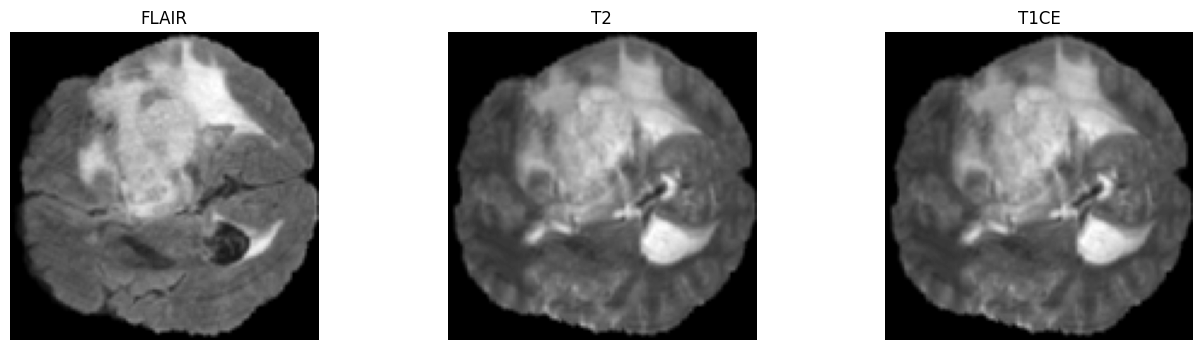

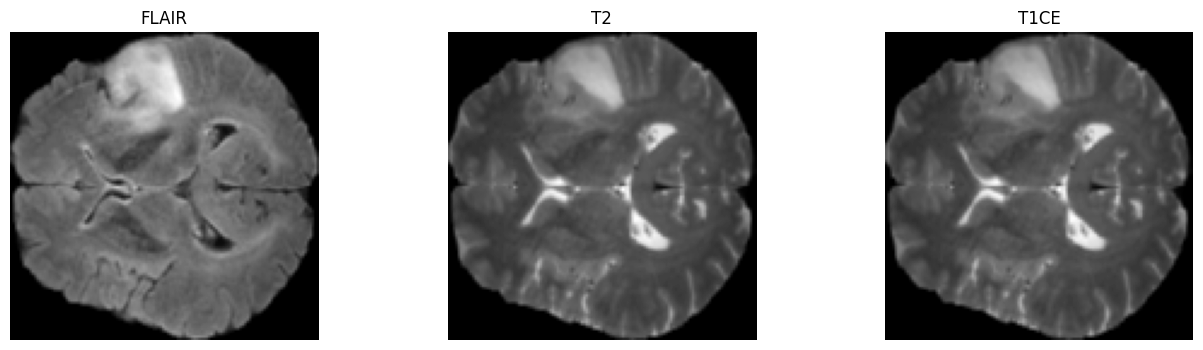

Processed 369 patients successfully


In [4]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, Resized, ToTensord, SpatialCropd
)
from monai.data import Dataset, DataLoader

# مسارات الداتاسيت
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/processed"
os.makedirs(output_dir, exist_ok=True)

# قايمة الحالات
patient_list = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and not d.endswith(".csv")])

# إنشاء فولدرات لكل مريض
for patient in patient_list:
    os.makedirs(os.path.join(output_dir, patient), exist_ok=True)

# إعداد قايمة البيانات (FLAIR, T2, T1CE)
data_dicts = []
skipped_patients = []
for patient in patient_list:
    flair_path = os.path.join(data_dir, patient, f"{patient}_flair.nii")
    t2_path = os.path.join(data_dir, patient, f"{patient}_t2.nii")
    t1ce_path = os.path.join(data_dir, patient, f"{patient}_t1ce.nii")
    try:
        # فحص وجود الملفات
        if not (os.path.exists(flair_path) and os.path.exists(t2_path) and os.path.exists(t1ce_path)):
            skipped_patients.append((patient, "Missing file(s)"))
            continue
        # فحص تحميل الملفات
        nib.load(flair_path)
        nib.load(t2_path)
        nib.load(t1ce_path)
        data_dicts.append({
            "flair": flair_path,
            "t2": t2_path,
            "t1ce": t1ce_path,
        })
    except Exception as e:
        skipped_patients.append((patient, f"Failed to load files: {str(e)}"))
        continue

# تعريف التحويلات
transforms = Compose([
    LoadImaged(keys=["flair", "t2", "t1ce"]),
    EnsureChannelFirstd(keys=["flair", "t2", "t1ce"]),
    Spacingd(keys=["flair", "t2", "t1ce"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    ScaleIntensityRanged(keys=["flair", "t2", "t1ce"], a_min=0, a_max=4000, b_min=0, b_max=1, clip=True),
    CropForegroundd(keys=["flair", "t2", "t1ce"], source_key="flair", allow_smaller=False),
    Resized(keys=["flair", "t2", "t1ce"], spatial_size=(128, 128, 155)),
    SpatialCropd(keys=["flair", "t2", "t1ce"], roi_start=[0, 0, 30], roi_end=[128, 128, 126]),  # 128x128x96
    ToTensord(keys=["flair", "t2", "t1ce"])
])

# إعداد الداتاسيت والـ DataLoader
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

# معالجة وحفظ الصور
processed_count = 0
display_patients = patient_list[:2]  # أول اتنين بيشنت للعرض
display_images = []

for i, data in enumerate(dataloader):
    if i >= len(data_dicts):
        break
    patient_id = data_dicts[i]["flair"].split("/")[-2]  # استخراج patient_id من المسار
    
    patient_output_dir = os.path.join(output_dir, patient_id)
    
    flair, t2, t1ce = data["flair"][0], data["t2"][0], data["t1ce"][0]
    
    # تحويل إلى NumPy لحفظها
    flair_np = flair.numpy().squeeze()
    t2_np = t2.numpy().squeeze()
    t1ce_np = t2.numpy().squeeze()
    
    # حفظ الصور كـ NIFTI
    for modality, img in [("flair", flair_np), ("t2", t2_np), ("t1ce", t1ce_np)]:
        output_path = os.path.join(patient_output_dir, f"{modality}.nii.gz")
        nii_img = nib.Nifti1Image(img, affine=np.eye(4))
        nib.save(nii_img, output_path)
    
    # تخزين الصور للعرض
    if patient_id in display_patients:
        display_images.append({
            "patient_id": patient_id,
            "flair": flair_np[:, :, 48],
            "t2": t2_np[:, :, 48],
            "t1ce": t1ce_np[:, :, 48]
        })
    
    processed_count += 1

# عرض الصور
for patient_data in display_images:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].imshow(patient_data["flair"], cmap="gray")
    axes[0].set_title("FLAIR")
    axes[0].axis("off")
    axes[1].imshow(patient_data["t2"], cmap="gray")
    axes[1].set_title("T2")
    axes[1].axis("off")
    axes[2].imshow(patient_data["t1ce"], cmap="gray")
    axes[2].set_title("T1CE")
    axes[2].axis("off")
    plt.show()

# طباعة النتائج
print(f"Processed {processed_count} patients successfully")
if skipped_patients:
    print("Skipped patients:")
    for patient, reason in skipped_patients:
        print(f"Patient {patient}: {reason}")
if processed_count < len(patient_list):
    print(f"Warning: Expected to process {len(patient_list)} patients, but only processed {processed_count}")

تمت معالجة المريض BraTS20_Training_001 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_002 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_003 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_004 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_005 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_006 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_007 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_008 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_009 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_010 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_011 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_012 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_013 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_014 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20_Training_015 بنجاح وحفظ الصورة المدمجة
تمت معالجة المريض BraTS20

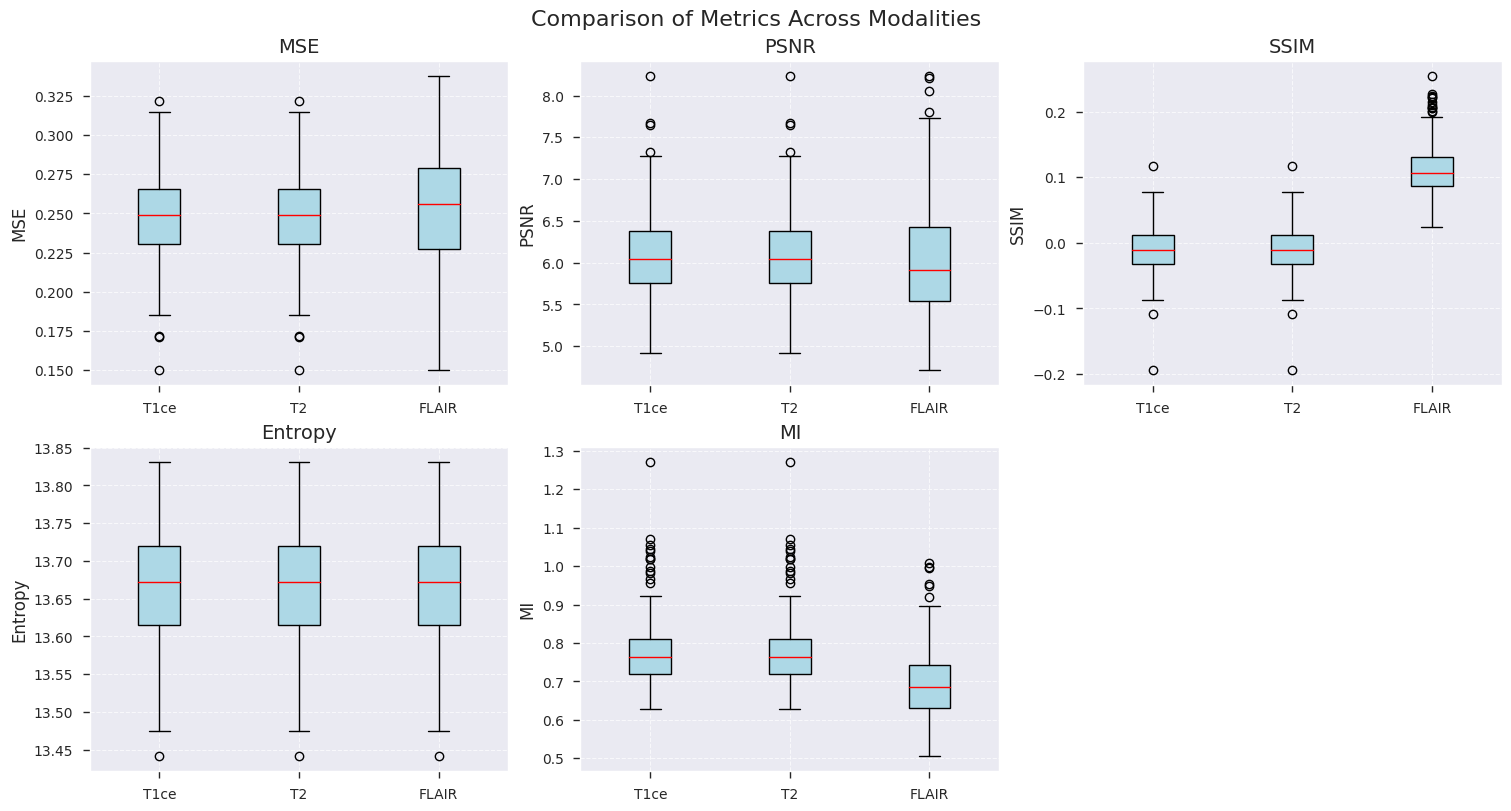

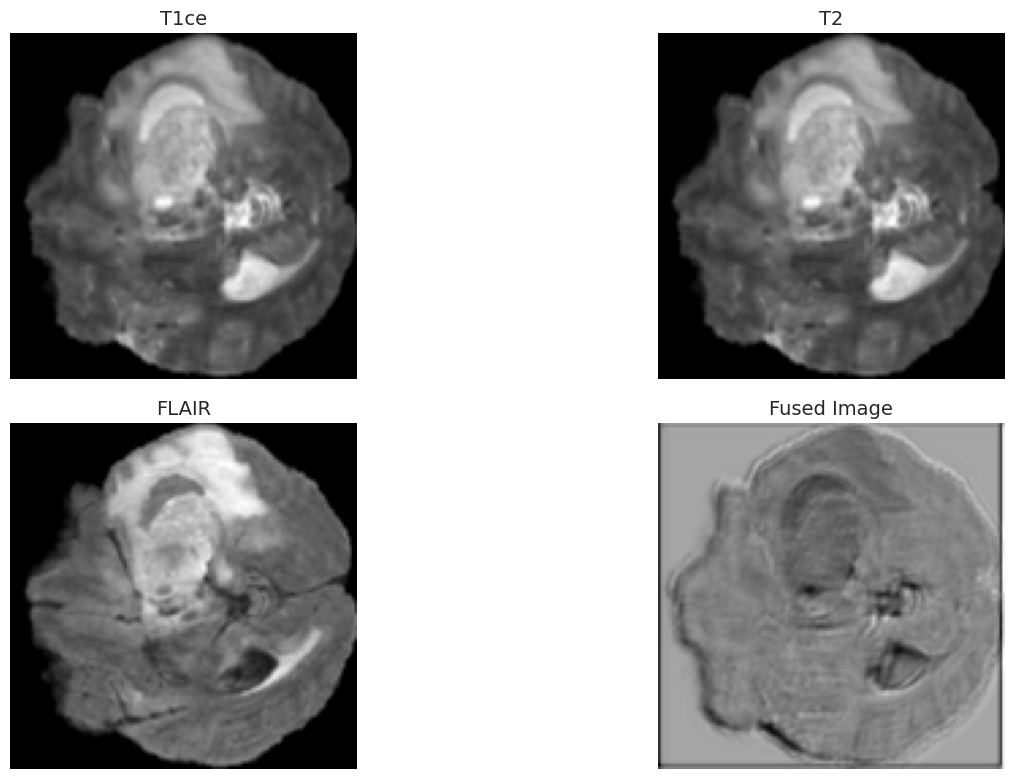

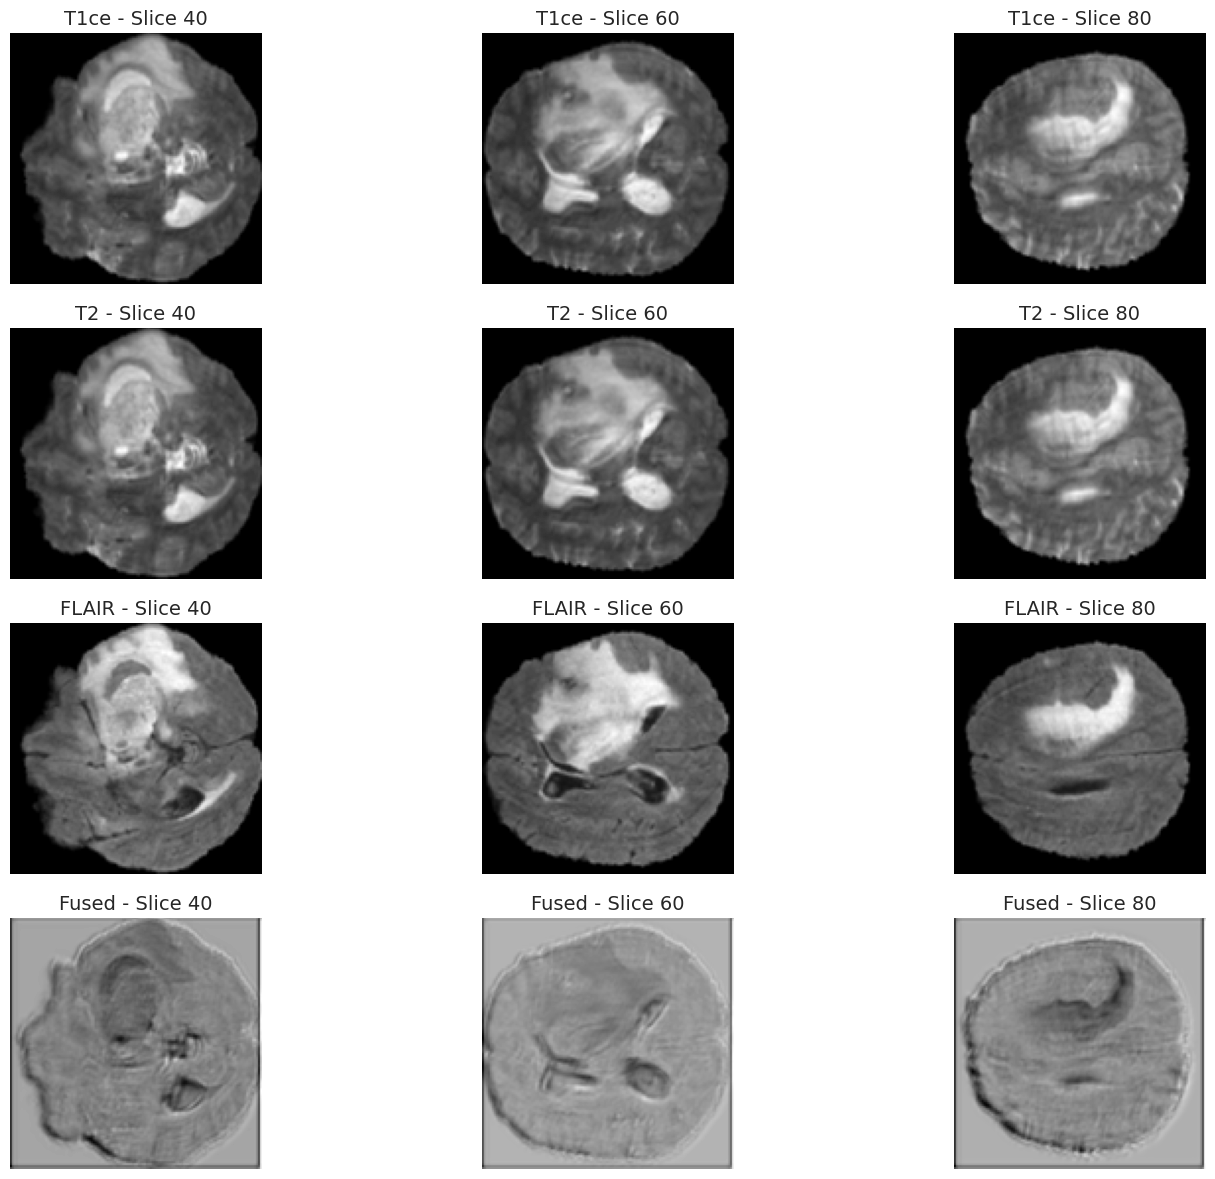

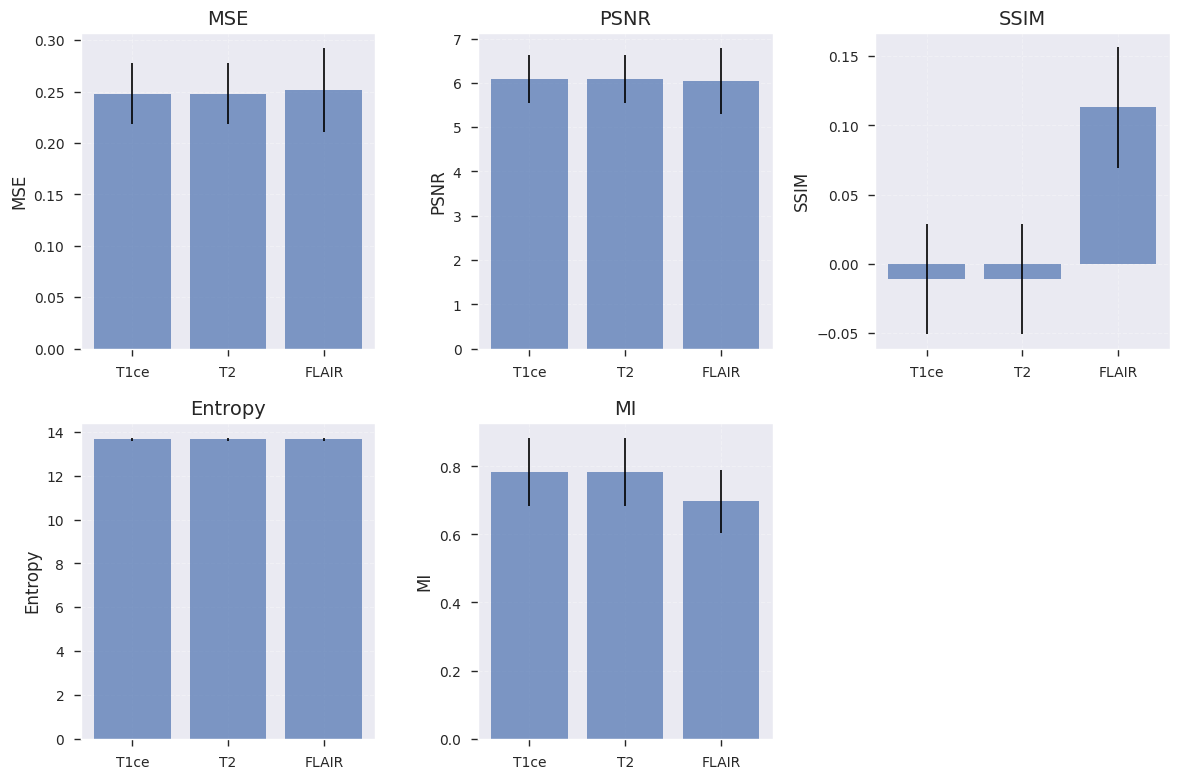

In [8]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from skimage.measure import shannon_entropy
from scipy.ndimage import gaussian_filter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set plotting style for research paper
plt.style.use('seaborn')
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

def normalize_image_slice(img_slice):
    """تطبيع شريحة واحدة من الصورة"""
    min_val = np.min(img_slice)
    max_val = np.max(img_slice)
    if max_val > min_val:
        return (img_slice - min_val) / (max_val - min_val)
    return img_slice

def normalize_image(img):
    """تطبيع الصورة بالكامل"""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

def mutual_information(img1, img2, bins=256):
    """حساب المعلومات المتبادلة بين صورتين بطريقة أكثر دقة"""
    # Flatten images
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    # Compute histograms
    hist_2d, x_edges, y_edges = np.histogram2d(img1_flat, img2_flat, bins=bins)
    hist_2d = hist_2d / np.sum(hist_2d)  # Normalize to get joint probability
    hist_1 = np.sum(hist_2d, axis=1)
    hist_2 = np.sum(hist_2d, axis=0)
    
    # Compute entropies
    mi = 0
    for i in range(bins):
        for j in range(bins):
            if hist_2d[i, j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    return mi

def post_process(img, sigma=0.5):
    """معالجة ما بعد الدمج باستخدام مرشح جاوسي"""
    return gaussian_filter(img, sigma=sigma)

# ----------------- تحسين معمارية المولد -----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class EnhancedFusionGenerator(nn.Module):
    def __init__(self):
        super(EnhancedFusionGenerator, self).__init__()
        # زيادة عدد الفلاتر وإضافة BatchNorm
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            ResidualBlock(64),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # إضافة طبقات إضافية للديكودر
        self.decoder = nn.Sequential(
            ResidualBlock(32),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# ----------------- إعداد الجهاز والنموذج -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedFusionGenerator().to(device)
model.eval()

# ----------------- تحميل البيانات -----------------
output_dir = "/kaggle/working/processed"
results_dir = os.path.join("/kaggle/working", "metrics_final")
os.makedirs(results_dir, exist_ok=True)

# الحصول على قائمة المرضى من مجلد الإخراج
patients = sorted(os.listdir(output_dir))[:150]

# تهيئة قواميس لتخزين المقاييس لكل مودالتي
metrics = {'T1ce': [], 'T2': [], 'FLAIR': []}

# ----------------- دمج وتقييم الصور -----------------
for patient in patients:
    folder = os.path.join(output_dir, patient)
    
    # قراءة الصور المعالجة من مجلد الإخراج - فقط المودالتي الثلاثة المطلوبة
    t1ce_path = os.path.join(folder, "t1ce.nii.gz")
    t2_path = os.path.join(folder, "t2.nii.gz")
    flair_path = os.path.join(folder, "flair.nii.gz")
    
    # التأكد من وجود الملفات
    if not (os.path.exists(t1ce_path) and os.path.exists(t2_path) and os.path.exists(flair_path)):
        print(f"تخطي المريض {patient} بسبب عدم وجود بعض الملفات")
        continue
    
    try:
        # قراءة الصور
        t1ce_data = nib.load(t1ce_path)
        t2_data = nib.load(t2_path)
        flair_data = nib.load(flair_path)
        
        # الحصول على مصفوفة البيانات والـ affine
        t1ce = t1ce_data.get_fdata()
        t2 = t2_data.get_fdata()
        flair = flair_data.get_fdata()
        affine = t1ce_data.affine  # حفظ الـ affine للاستخدام لاحقاً
        
        # التأكد من أن الصور لها نفس الأبعاد
        if not (t1ce.shape == t2.shape == flair.shape):
            print(f"تخطي المريض {patient} بسبب اختلاف أبعاد الصور")
            continue
        
        # تطبيع الصور
        t1ce_norm = normalize_image(t1ce)
        t2_norm = normalize_image(t2)
        flair_norm = normalize_image(flair)
        
        # تهيئة مصفوفة للصور المدمجة
        fused = np.zeros_like(t1ce)
        
        # تطبيق النموذج على كل شريحة مع تطبيع محسن
        with torch.no_grad():
            for i in range(t1ce.shape[2]):
                # تطبيع كل شريحة على حدة للحصول على تباين أفضل
                t1ce_slice = normalize_image_slice(t1ce_norm[:, :, i])
                t2_slice = normalize_image_slice(t2_norm[:, :, i])
                flair_slice = normalize_image_slice(flair_norm[:, :, i])
                
                # تكديس الشرائح - فقط المودالتي الثلاثة المطلوبة
                slice_stack = np.stack([t1ce_slice, t2_slice, flair_slice], axis=0)
                slice_tensor = torch.tensor(slice_stack, dtype=torch.float32).unsqueeze(0).to(device)
                
                # تطبيق النموذج
                fused_slice = model(slice_tensor)
                fused[:, :, i] = fused_slice.squeeze().cpu().numpy()
        
        # معالجة ما بعد الدمج (تنعيم جاوسي خفيف)
        fused = post_process(fused, sigma=0.5)
        
        # تطبيع نهائي للصورة المدمجة
        fused = normalize_image(fused)
        
        # حفظ الصورة المدمجة مع الـ affine الصحيح
        fused_output_path = os.path.join(folder, "fused_final_3d.nii.gz")
        nii_img = nib.Nifti1Image(fused, affine=affine)
        nib.save(nii_img, fused_output_path)
        
        # حساب المقاييس لكل مودالتي
        for name, original in zip(['T1ce', 'T2', 'FLAIR'], [t1ce_norm, t2_norm, flair_norm]):
            # اختيار الشرائح المهمة (30:110) كما في الملف المرجعي
            slice_range = slice(30, min(110, original.shape[2]))
            fused_slices = fused[:, :, slice_range]
            original_slices = original[:, :, slice_range]
            
            # حساب المقاييس الأساسية
            mse = mean_squared_error(fused_slices, original_slices)
            psnr = peak_signal_noise_ratio(fused_slices, original_slices, data_range=1.0)
            
            # حساب SSIM لكل شريحة ثم المتوسط
            ssim_values = []
            for j in range(fused_slices.shape[2]):
                ssim_values.append(structural_similarity(fused_slices[:, :, j], original_slices[:, :, j], data_range=1.0))
            ssim = np.mean(ssim_values)
            
            # حساب Entropy
            entropy_values = []
            for j in range(fused_slices.shape[2]):
                entropy_values.append(shannon_entropy(fused_slices[:, :, j]))
            entropy = np.mean(entropy_values)
            
            # حساب Mutual Information باستخدام الدالة المحسنة
            mi = mutual_information(fused_slices, original_slices)
            
            metrics[name].append({
                'Patient': patient,
                'MSE': mse,
                'PSNR': psnr,
                'SSIM': ssim,
                'Entropy': entropy,
                'MI': mi,
                'Num_Slices': fused_slices.shape[2]  # إضافة عدد الشرائح للتحليل
            })
        
        print(f"تمت معالجة المريض {patient} بنجاح وحفظ الصورة المدمجة")
        
    except Exception as e:
        print(f"خطأ في معالجة المريض {patient}: {str(e)}")
        continue

# ----------------- حفظ وعرض النتائج -----------------
# حفظ المقاييس لكل مودالتي
for name in metrics:
    if len(metrics[name]) == 0:
        print(f"لا توجد بيانات لـ {name}")
        continue
        
    df = pd.DataFrame(metrics[name])
    metrics_path = os.path.join(results_dir, f'metrics_{name}.csv')
    df.to_csv(metrics_path, index=False)
    
    mse_avg = np.mean(df['MSE'])
    psnr_avg = np.mean(df['PSNR'])
    ssim_avg = np.mean(df['SSIM'])
    entropy_avg = np.mean(df['Entropy'])
    mi_avg = np.mean(df['MI'])
    
    print(f"نتائج {name} (دمج GAN النهائي):")
    print(f"MSE: {mse_avg:.6f}")
    print(f"PSNR: {psnr_avg:.4f}")
    print(f"SSIM: {ssim_avg:.4f}")
    print(f"Entropy: {entropy_avg:.4f}")
    print(f"MI: {mi_avg:.4f}")
    print("-" * 40)

# ----------------- إنشاء رسوم بيانية للمقاييس -----------------
# Metrics to plot
metrics_to_plot = ['MSE', 'PSNR', 'SSIM', 'Entropy', 'MI']

# Create Boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    data = []
    labels = []
    for modality in metrics:
        if len(metrics[modality]) > 0:
            values = [item[metric] for item in metrics[modality] if metric in item]
            if values:
                data.append(values)
                labels.append(modality)
    
    if idx < len(axes) and data:
        axes[idx].boxplot(data, labels=labels, patch_artist=True, 
                         boxprops=dict(facecolor='lightblue', color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         medianprops=dict(color='red'))
        axes[idx].set_title(metric)
        axes[idx].set_ylabel(metric)
        axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot if any
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Comparison of Metrics Across Modalities', fontsize=16)
plt.savefig(os.path.join(results_dir, 'boxplots_metrics.png'), dpi=300, bbox_inches='tight')

# ----------------- المقارنة البصرية -----------------
if len(patients) > 0:
    try:
        first_patient = patients[0]
        first_patient_dir = os.path.join(output_dir, first_patient)
        
        # قراءة الصور - فقط المودالتي الثلاثة المطلوبة
        t1ce = normalize_image(nib.load(os.path.join(first_patient_dir, "t1ce.nii.gz")).get_fdata())
        t2 = normalize_image(nib.load(os.path.join(first_patient_dir, "t2.nii.gz")).get_fdata())
        flair = normalize_image(nib.load(os.path.join(first_patient_dir, "flair.nii.gz")).get_fdata())
        
        # قراءة الصورة المدمجة النهائية
        fused_final_path = os.path.join(first_patient_dir, "fused_final_3d.nii.gz")
        if os.path.exists(fused_final_path):
            fused_final = normalize_image(nib.load(fused_final_path).get_fdata())
            
            # اختيار شريحة مناسبة للعرض
            slice_index = min(40, t1ce.shape[2] - 1)
            
            # عرض مقارنة بين الصور الأصلية والمدمجة
            plt.figure(figsize=(16, 8))
            
            plt.subplot(2, 2, 1); plt.imshow(t1ce[:, :, slice_index], cmap='gray'); plt.title("T1ce"); plt.axis('off')
            plt.subplot(2, 2, 2); plt.imshow(t2[:, :, slice_index], cmap='gray'); plt.title("T2"); plt.axis('off')
            plt.subplot(2, 2, 3); plt.imshow(flair[:, :, slice_index], cmap='gray'); plt.title("FLAIR"); plt.axis('off')
            plt.subplot(2, 2, 4); plt.imshow(fused_final[:, :, slice_index], cmap='gray'); plt.title("Fused Image"); plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, "visual_comparison_final.png"), dpi=300, bbox_inches='tight')
            
            # عرض مقارنة متعددة الشرائح
            plt.figure(figsize=(16, 12))
            
            # عرض ثلاث شرائح مختلفة
            slices = [slice_index, min(slice_index + 20, t1ce.shape[2] - 1), min(slice_index + 40, t1ce.shape[2] - 1)]
            
            for i, s in enumerate(slices):
                plt.subplot(4, 3, i+1); plt.imshow(t1ce[:, :, s], cmap='gray'); plt.title(f"T1ce - Slice {s}"); plt.axis('off')
                plt.subplot(4, 3, i+4); plt.imshow(t2[:, :, s], cmap='gray'); plt.title(f"T2 - Slice {s}"); plt.axis('off')
                plt.subplot(4, 3, i+7); plt.imshow(flair[:, :, s], cmap='gray'); plt.title(f"FLAIR - Slice {s}"); plt.axis('off')
                plt.subplot(4, 3, i+10); plt.imshow(fused_final[:, :, s], cmap='gray'); plt.title(f"Fused - Slice {s}"); plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, "multi_slice_comparison.png"), dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"خطأ في عرض المقارنة البصرية: {str(e)}")

print(f"تم حفظ جميع النتائج في المجلد: {results_dir}")
print(f"تم معالجة {len(metrics['T1ce'])} مريض بنجاح من أصل {len(patients)}")

# ----------------- تحليل إضافي للنتائج -----------------
# إنشاء مخطط مقارنة بين المودالتي الثلاثة
try:
    # تجميع البيانات من جميع المودالتي
    all_metrics = {}
    for metric in metrics_to_plot:
        all_metrics[metric] = {modality: [] for modality in metrics.keys()}
        for modality in metrics:
            if len(metrics[modality]) > 0:
                all_metrics[metric][modality] = [item[metric] for item in metrics[modality] if metric in item]
    
    # إنشاء مخطط شريطي للمقارنة
    plt.figure(figsize=(12, 8))
    
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 3, i+1)
        means = [np.mean(all_metrics[metric][modality]) if all_metrics[metric][modality] else 0 for modality in metrics.keys()]
        stds = [np.std(all_metrics[metric][modality]) if all_metrics[metric][modality] else 0 for modality in metrics.keys()]
        
        bars = plt.bar(list(metrics.keys()), means, yerr=stds, capsize=10, alpha=0.7)
        
        plt.title(metric)
        plt.ylabel(metric)
        plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "metrics_comparison_bar.png"), dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"خطأ في إنشاء مخطط المقارنة: {str(e)}")
